# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import splitfolders
class config:
   

    
    data_path = 'real_and_fake_face_detection/real_and_fake_face/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [3]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.9, .1))

Copying files: 2041 files [00:12, 158.19 files/s]


# Loading Data

In [4]:
train_path = "output/train"
validation_path = "output/val"
test_path = "output/val"

image_categories = os.listdir('output/train')

In [5]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

# 2. Validation Set
val_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
val_image_generator = train_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

# 3. Test Set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
test_image_generator = train_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 1836 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [6]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'training_fake', 1: 'training_real'}


# CNN

In [7]:
model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               11214976  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [8]:
early_stopping = keras.callbacks.EarlyStopping(patience=5) # Set up callbacks
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
hist = model.fit(train_image_generator, 
                 epochs=100, 
                 verbose=1, 
                 validation_data=val_image_generator, 
                 steps_per_epoch = 1836//32, 
                 validation_steps = 205//32, 
                 callbacks=early_stopping)

Epoch 1/100
57/57 [==============================] - 26s 464ms/step - loss: 0.7941 - accuracy: 0.5172 - val_loss: 0.6878 - val_accuracy: 0.5312
Epoch 2/100
57/57 [==============================] - 24s 420ms/step - loss: 0.6806 - accuracy: 0.5732 - val_loss: 0.6806 - val_accuracy: 0.5573
Epoch 3/100
57/57 [==============================] - 24s 418ms/step - loss: 0.6545 - accuracy: 0.6192 - val_loss: 0.7092 - val_accuracy: 0.5938
Epoch 4/100
57/57 [==============================] - 24s 416ms/step - loss: 0.5624 - accuracy: 0.7151 - val_loss: 0.7972 - val_accuracy: 0.6042
Epoch 5/100
57/57 [==============================] - 24s 418ms/step - loss: 0.4133 - accuracy: 0.8137 - val_loss: 0.9083 - val_accuracy: 0.5833
Epoch 6/100
57/57 [==============================] - 24s 418ms/step - loss: 0.2517 - accuracy: 0.8991 - val_loss: 1.3781 - val_accuracy: 0.5729
Epoch 7/100
57/57 [==============================] - 24s 419ms/step - loss: 0.1464 - accuracy: 0.9484 - val_loss: 1.4563 - val_accuracy:

In [9]:
model.save('model.h5')

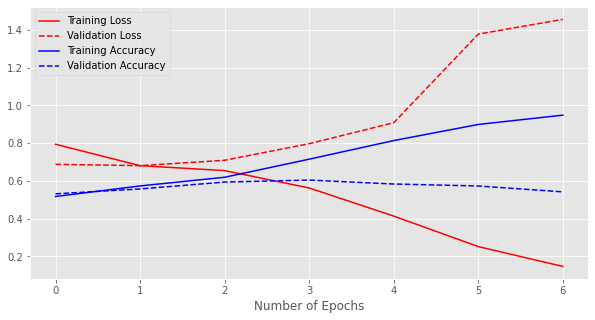

In [10]:
# Plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [11]:
model.evaluate(test_image_generator)

7/7 [==============================] - 2s 267ms/step - loss: 1.5316 - accuracy: 0.5415


[1.5315849781036377, 0.5414634346961975]

# Transfer Learning

In [12]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [13]:
train_path = 'output/train'
test_path = 'output/val'

# Image Scaling & Processing

In [14]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=8,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=8,
                                            class_mode='categorical')

Found 1836 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [16]:
IMAGE_SIZE = [224,224]

# MobileNetV2

In [17]:
from tensorflow.keras.models import Model
import tensorflow as tf
inc = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [18]:
x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)

In [19]:
modelss = Model(inputs = inc.inputs, outputs = predictionss)
modelss.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [20]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
modelss.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
r2 = modelss.fit_generator(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set), callbacks=early_stopping)
x=r2

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
230/230 [==============================] - 196s 851ms/step - loss: 3.2181 - accuracy: 0.5289 - val_loss: 10.7262 - val_accuracy: 0.4683
Epoch 2/20
230/230 [==============================] - 188s 818ms/step - loss: 2.3610 - accuracy: 0.5327 - val_loss: 72.9249 - val_accuracy: 0.5317
Epoch 3/20
230/230 [==============================] - 188s 817ms/step - loss: 1.9883 - accuracy: 0.5131 - val_loss: 55.4864 - val_accuracy: 0.5317
Epoch 4/20
230/230 [==============================] - 189s 822ms/step - loss: 2.5506 - accuracy: 0.5261 - val_loss: 12.9552 - val_accuracy: 0.5317
Epoch 5/20
230/230 [==============================] - 188s 819ms/step - loss: 2.5770 - accuracy: 0.5289 - val_loss: 5.5708 - val_accuracy: 0.5317
Epoch 6/20
230/230 [==============================] - 188s 818ms/step - loss: 2.4301 - accuracy: 0.5196 - val_loss: 4.3404 - val_accuracy: 0.5268
Epoch 7/20
230/230 [========================

In [21]:
modelss.save('mobilenetv2.h5')

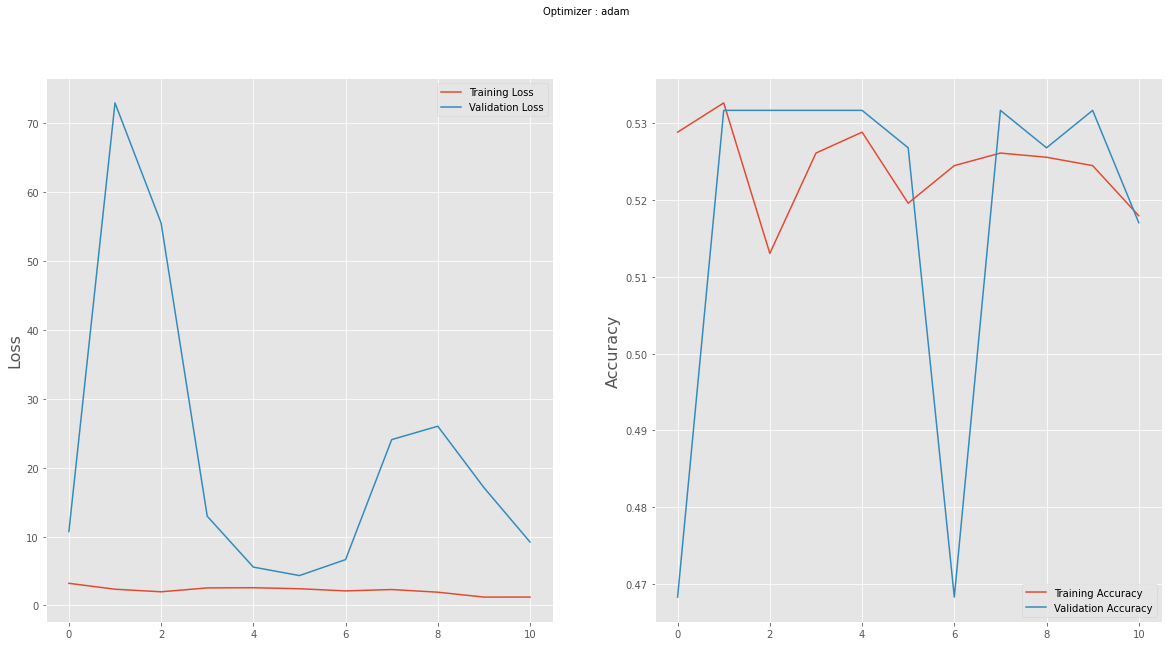

In [22]:
import matplotlib.pyplot as plt

x=r2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# InceptionV3

In [23]:
inc = tf.keras.applications.inception_v3.InceptionV3(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [24]:
x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)

In [25]:
modelss = Model(inputs = inc.inputs, outputs = predictionss)
modelss.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [26]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
modelss.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
r2 = modelss.fit_generator(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set), callbacks=early_stopping)
x=r2

Epoch 1/20
230/230 [==============================] - 375s 2s/step - loss: 1.5932 - accuracy: 0.4809 - val_loss: 416.7362 - val_accuracy: 0.4732
Epoch 2/20
230/230 [==============================] - 352s 2s/step - loss: 1.0384 - accuracy: 0.4935 - val_loss: 473.4317 - val_accuracy: 0.5024
Epoch 3/20
230/230 [==============================] - 351s 2s/step - loss: 0.8876 - accuracy: 0.4837 - val_loss: 6.5882 - val_accuracy: 0.5024
Epoch 4/20
230/230 [==============================] - 351s 2s/step - loss: 0.7932 - accuracy: 0.5240 - val_loss: 9.7388 - val_accuracy: 0.4195
Epoch 5/20
230/230 [==============================] - 351s 2s/step - loss: 0.8258 - accuracy: 0.5049 - val_loss: 0.9618 - val_accuracy: 0.5415
Epoch 6/20
230/230 [==============================] - 351s 2s/step - loss: 0.7938 - accuracy: 0.5212 - val_loss: 0.6925 - val_accuracy: 0.5366
Epoch 7/20
230/230 [==============================] - 351s 2s/step - loss: 0.7663 - accuracy: 0.5158 - val_loss: 1.0202 - val_accuracy: 0.

In [27]:
modelss.save('inception.h5')

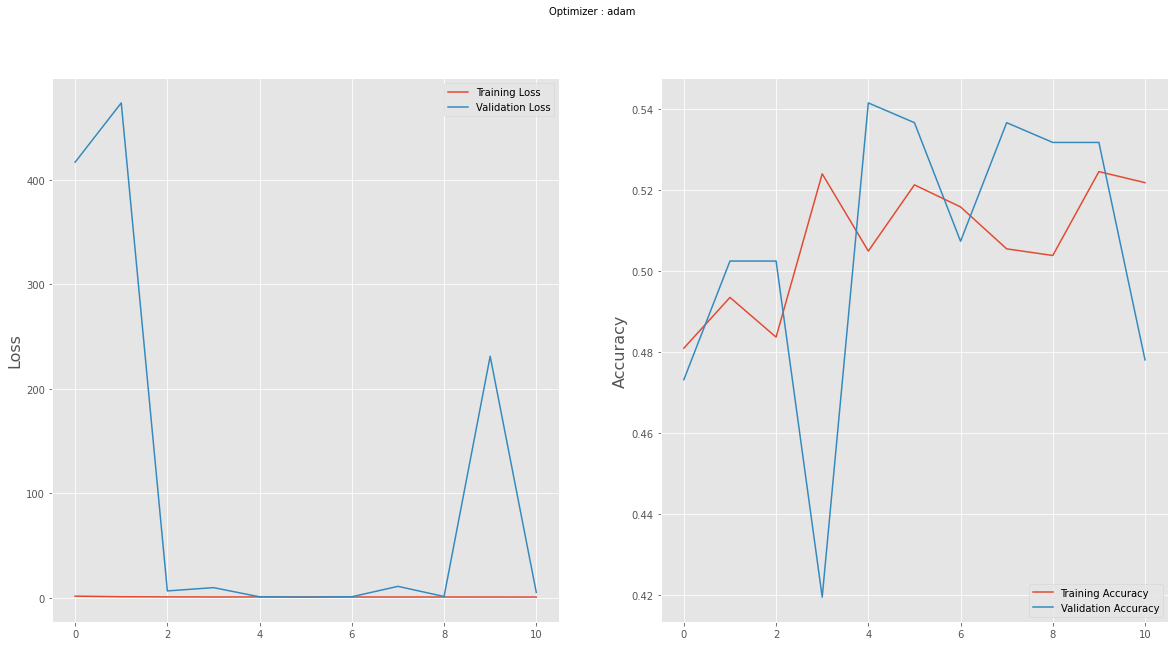

In [28]:
import matplotlib.pyplot as plt

x=r2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet

In [29]:
inc = tf.keras.applications.densenet.DenseNet121(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [30]:
x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)

In [31]:
modelss = Model(inputs = inc.inputs, outputs = predictionss)
modelss.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [32]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
modelss.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
r2 = modelss.fit_generator(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set), callbacks=early_stopping)
x=r2

Epoch 1/20
230/230 [==============================] - 484s 2s/step - loss: 6.1269 - accuracy: 0.5076 - val_loss: 5102.7642 - val_accuracy: 0.4829
Epoch 2/20
230/230 [==============================] - 455s 2s/step - loss: 4.0667 - accuracy: 0.5076 - val_loss: 14.0864 - val_accuracy: 0.5024
Epoch 3/20
230/230 [==============================] - 455s 2s/step - loss: 2.7310 - accuracy: 0.5218 - val_loss: 1655.5857 - val_accuracy: 0.5024
Epoch 4/20
230/230 [==============================] - 455s 2s/step - loss: 2.4626 - accuracy: 0.5169 - val_loss: 1.5464 - val_accuracy: 0.5512
Epoch 5/20
230/230 [==============================] - 455s 2s/step - loss: 1.7160 - accuracy: 0.5234 - val_loss: 3.5157 - val_accuracy: 0.5220
Epoch 6/20
230/230 [==============================] - 458s 2s/step - loss: 1.4585 - accuracy: 0.5447 - val_loss: 1.1543 - val_accuracy: 0.5805
Epoch 7/20
230/230 [==============================] - 455s 2s/step - loss: 1.4742 - accuracy: 0.5267 - val_loss: 28.9277 - val_accuracy

In [33]:
modelss.save('densenet.h5')

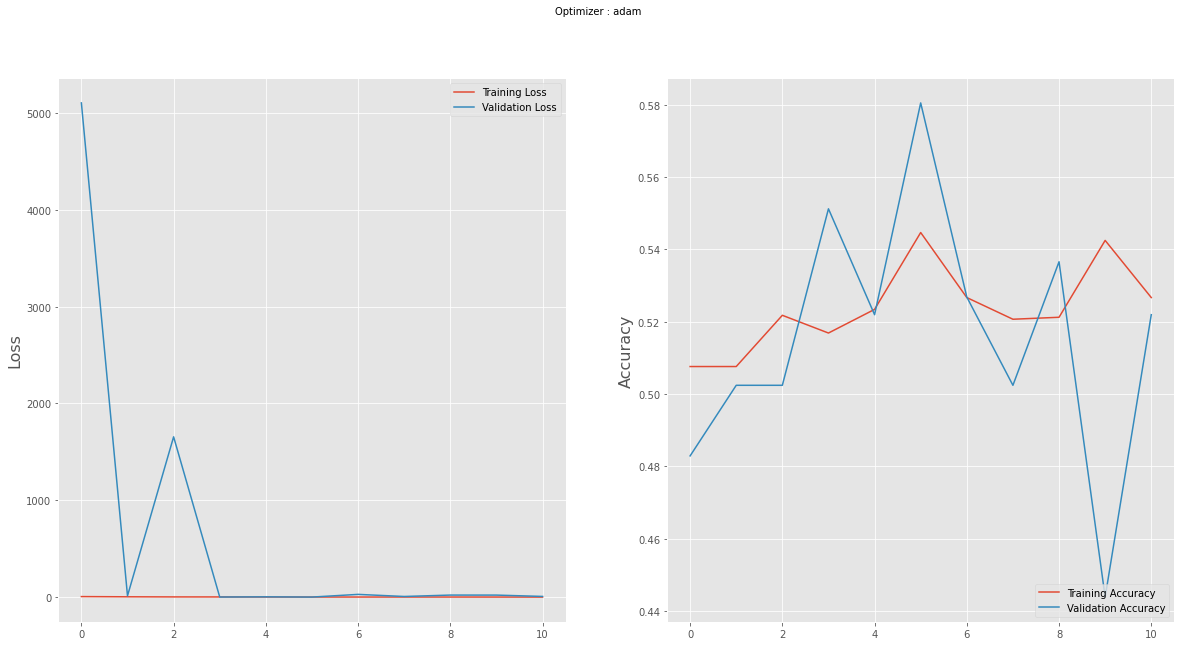

In [34]:
import matplotlib.pyplot as plt

x=r2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Torch

In [35]:
import numpy as np
import os
import pathlib
import skimage.io as io
import skimage.transform as sktransform
import skimage.color as color
import torch

import tensorflow as tf

In [36]:
!pip install haroun==0.1.1

# import my Library (Pytorch Framework)
from haroun import Data, Model, ConvPool
from haroun.augmentation import augmentation
from haroun.losses import rmse

In [37]:
from pathlib import Path
def load_data():
    path =  Path('real_and_fake_face_detection/real_and_fake_face/')
    images = []
    labels = []


    for directory in os.listdir(path):
        data_path = path / directory
        
        for im in os.listdir(data_path)[:]:
            image = io.imread(f"{data_path}/{im}")
            image = sktransform.resize(image, (64, 64))
            images.append(image)
            if directory == "training_fake":
                labels.append("fake")
            elif directory == "training_real":
                labels.append("real")
    

    images = np.array(images)
    labels = np.array(labels)

    images, labels = augmentation(images, labels, flip_y=True, flip_x=True, brightness=True)

    return images, labels

In [38]:
classes = {'real': 0, 'fake': 1}
data = Data(loader=load_data(), classes=classes)
data.shape()

Data loaded successfully :)
Images shape: (24492, 64, 64, 3) Labels shape: (24492,)



In [39]:
data.stat()

{'real': 12972, 'fake': 11520}


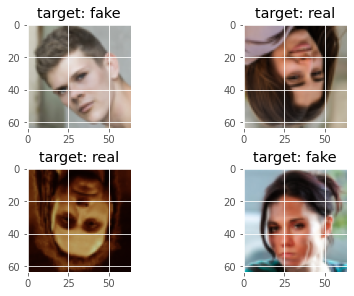

In [40]:
data.show()

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.dataset(split_size=0.05, shuffle=True, random_state=42,
             images_format=torch.float32, labels_format=torch.float32,
             permute=True, one_hot=True, device=device)

Train tensor shape: torch.Size([23267, 3, 64, 64]), torch.Size([23267, 2])
Test tensor shape: torch.Size([612, 3, 64, 64]), torch.Size([612, 2])
Validation tensor shape: torch.Size([613, 3, 64, 64]), torch.Size([613, 2])

Dataset generated successfully :)


In [42]:
class Network(torch.nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(3, affine=False)
        self.layer1 = ConvPool(in_features=3, out_features=8)
        self.layer2 = ConvPool(in_features=8, out_features=16)
        self.layer3 = ConvPool(in_features=16, out_features=32)
        self.layer4 = ConvPool(in_features=32, out_features=64)
        self.layer5 = ConvPool(in_features=64, out_features=128)
        self.layer6 = ConvPool(in_features=128, out_features=256)
        
        

        self.net = torch.nn.Sequential(self.layer1, self.layer2, self.layer3, 
                                       self.layer4, self.layer5, self.layer6)
            
        
        self.fc1 = torch.nn.Linear(in_features=256, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=2)


        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.input_norm(X)
        X = self.net(X)
        X = X.reshape(X.size(0), -1)
        X = self.lin(X)
        X = torch.nn.functional.elu(X, alpha=1.0, inplace=False)
        return X

In [43]:
net = Network()
AntiSpoofClassifier = Model(net, "adam", rmse, device)
AntiSpoofClassifier.train(train_data=(data.train_inputs, data.train_outputs),
                          val_data=(data.val_inputs, data.val_outputs),
                          epochs=200, patience=20, batch_size=100, learning_rate=1.0E-3)

Model initialized succssefully :)

Train loop:

	Epoch: 1/200,  Train Loss: 0.0729,  Val Loss: 0.0685
	Epoch: 2/200,  Train Loss: 0.0635,  Val Loss: 0.0652
	Epoch: 3/200,  Train Loss: 0.0572,  Val Loss: 0.0658 - No improvement -> Remaining patience: 19
	Epoch: 4/200,  Train Loss: 0.0492,  Val Loss: 0.0539
	Epoch: 5/200,  Train Loss: 0.0394,  Val Loss: 0.0504
	Epoch: 6/200,  Train Loss: 0.0331,  Val Loss: 0.0422
	Epoch: 7/200,  Train Loss: 0.0286,  Val Loss: 0.0364
	Epoch: 8/200,  Train Loss: 0.0247,  Val Loss: 0.0384 - No improvement -> Remaining patience: 19
	Epoch: 9/200,  Train Loss: 0.0226,  Val Loss: 0.0318
	Epoch: 10/200,  Train Loss: 0.0207,  Val Loss: 0.0342 - No improvement -> Remaining patience: 19
	Epoch: 11/200,  Train Loss: 0.0182,  Val Loss: 0.03
	Epoch: 12/200,  Train Loss: 0.0175,  Val Loss: 0.0308 - No improvement -> Remaining patience: 19
	Epoch: 13/200,  Train Loss: 0.0165,  Val Loss: 0.0287
	Epoch: 14/200,  Train Loss: 0.0152,  Val Loss: 0.0279
	Epoch: 15/200,  Trai

	Epoch: 96/200,  Train Loss: 0.00772,  Val Loss: 0.0153 - No improvement -> Remaining patience: 17
	Epoch: 97/200,  Train Loss: 0.00765,  Val Loss: 0.013 - No improvement -> Remaining patience: 16
	Epoch: 98/200,  Train Loss: 0.00817,  Val Loss: 0.0148 - No improvement -> Remaining patience: 15
	Epoch: 99/200,  Train Loss: 0.00826,  Val Loss: 0.0144 - No improvement -> Remaining patience: 14
	Epoch: 100/200,  Train Loss: 0.0081,  Val Loss: 0.0129 - No improvement -> Remaining patience: 13
	Epoch: 101/200,  Train Loss: 0.0073,  Val Loss: 0.0153 - No improvement -> Remaining patience: 12
	Epoch: 102/200,  Train Loss: 0.0072,  Val Loss: 0.0113
	Epoch: 103/200,  Train Loss: 0.00734,  Val Loss: 0.012 - No improvement -> Remaining patience: 19
	Epoch: 104/200,  Train Loss: 0.00814,  Val Loss: 0.018 - No improvement -> Remaining patience: 18
	Epoch: 105/200,  Train Loss: 0.00755,  Val Loss: 0.0131 - No improvement -> Remaining patience: 17
	Epoch: 106/200,  Train Loss: 0.00732,  Val Loss: 0.0

In [44]:
AntiSpoofClassifier.evaluate(test_data=(data.test_inputs, data.test_outputs))


Test accuracy:99%
Correct predictions: 606, Wrong predictions: 6


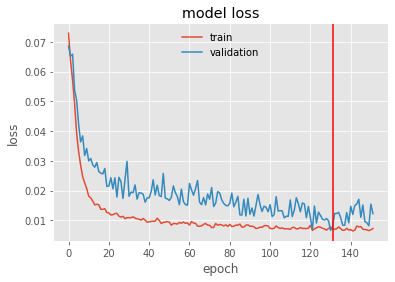


Checkpoint saved successfully :)


In [45]:
AntiSpoofClassifier.plot()
AntiSpoofClassifier.save(path="./", checkpoint_name="module")

In [46]:
PATH = "best.pt"

# Save only the state dictionary of the model
torch.save(AntiSpoofClassifier.net.state_dict(), PATH)